# 💳 Fraud Detection Using Machine Learning

This notebook builds a complete machine learning pipeline to detect fraudulent transactions using financial data. The steps include:

- Exploratory Data Analysis (EDA)
- Feature Engineering
- Data Preprocessing (Scaling, SMOTE)
- Dimensionality Reduction (PCA)
- Model Training & Evaluation
- Hyperparameter Tuning (RandomizedSearchCV & Optuna)

Let's begin by loading the necessary libraries and understanding our dataset.

### 📚 Importing Required Libraries
We use libraries like Pandas, NumPy, Seaborn for data handling, and scikit-learn, XGBoost, LightGBM for modeling.


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

### Load & Explore Data (Markdown + Code)

In [2]:
#Load Data
df = pd.read_csv(r"C:\Users\vasanth\Downloads\Telegram Desktop\Fraud_Analysis_Dataset.csv")

### Exploratory Data Analysis

### 🔍 Visualizing Fraud Trends
We'll visualize class imbalance, types of transactions, and amount distributions.

In [3]:
#Basic EDA
print(df.info())
print(df['isFraud'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 870.6+ KB
None
isFraud
0    0.897505
1    0.102495
Name: proportion, dtype: float64


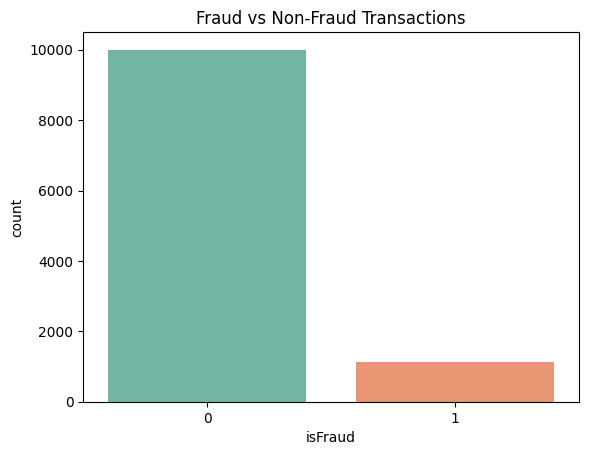

In [4]:
# Plot Fraud vs Non-Fraud
sns.countplot(x='isFraud', data=df, palette='Set2')
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

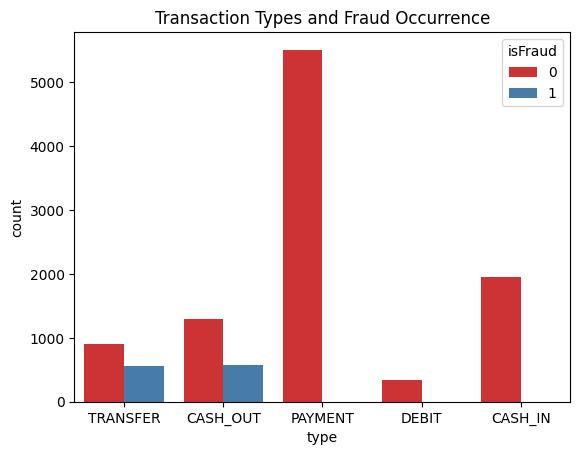

In [5]:
# Transaction Types vs Fraud
sns.countplot(x='type', data=df, hue='isFraud', palette='Set1')
plt.title('Transaction Types and Fraud Occurrence')
plt.show()

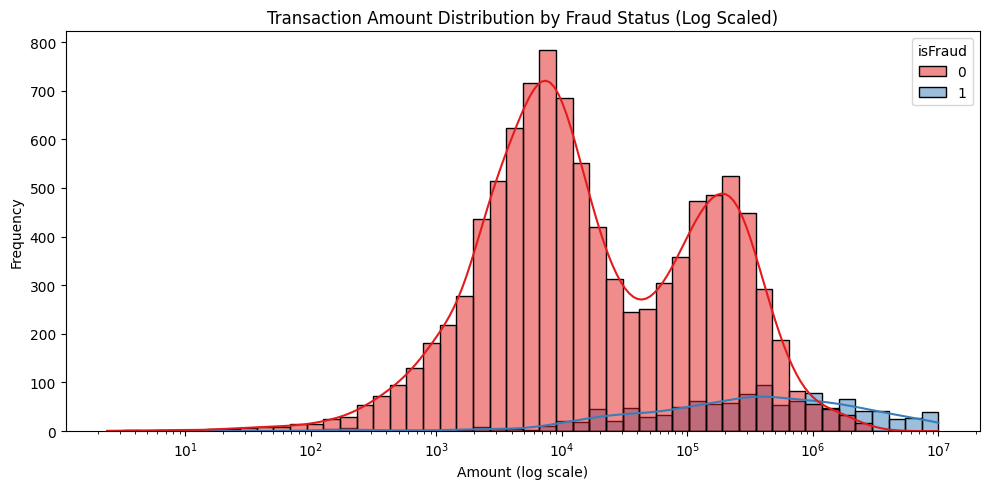

In [6]:
# Transaction Amount Distribution (Log-Scaled) by Fraud Status
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='amount', hue='isFraud', bins=50, kde=True, log_scale=(True, False), palette="Set1")
plt.title("Transaction Amount Distribution by Fraud Status (Log Scaled)")
plt.xlabel("Amount (log scale)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

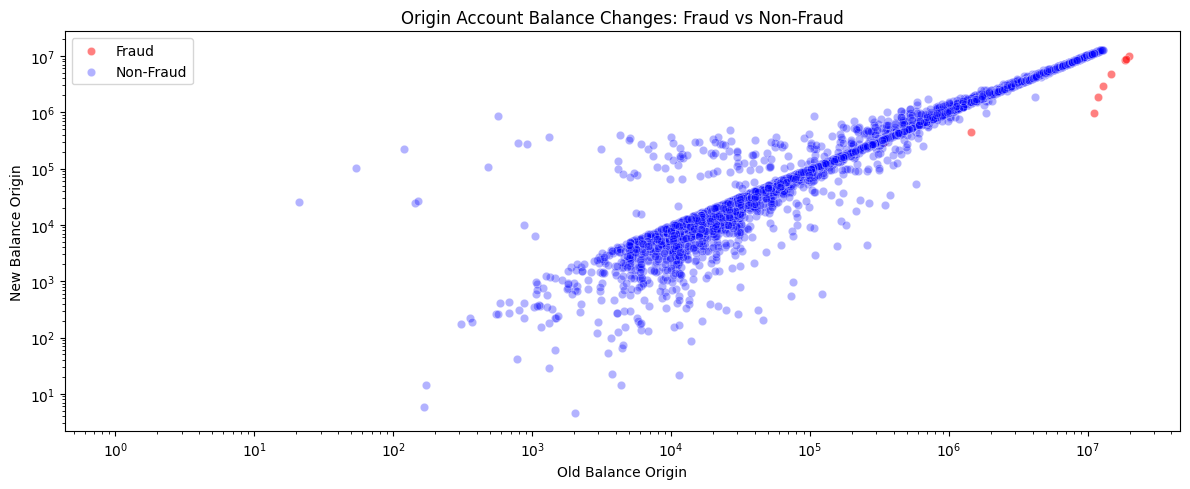

In [7]:
# Origin Account Balance Behavior
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df[df['isFraud'] == 1], 
                x='oldbalanceOrg', y='newbalanceOrig', 
                alpha=0.5, label='Fraud', color='red')
sns.scatterplot(data=df[df['isFraud'] == 0], 
                x='oldbalanceOrg', y='newbalanceOrig', 
                alpha=0.3, label='Non-Fraud', color='blue')
plt.title('Origin Account Balance Changes: Fraud vs Non-Fraud')
plt.xlabel('Old Balance Origin')
plt.ylabel('New Balance Origin')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

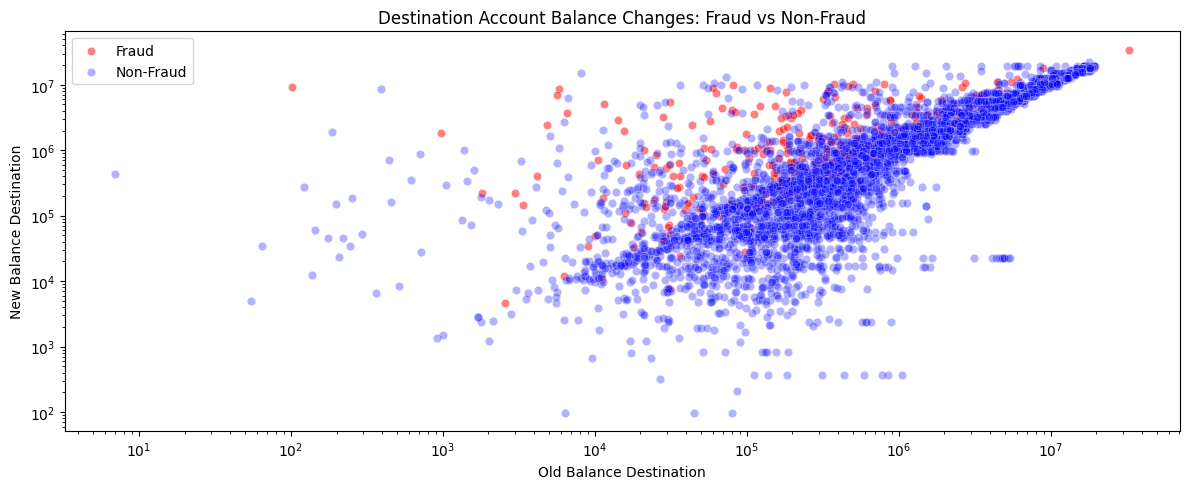

In [8]:
# Destination Account Balance Behavior
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df[df['isFraud'] == 1], 
                x='oldbalanceDest', y='newbalanceDest', 
                alpha=0.5, label='Fraud', color='red')
sns.scatterplot(data=df[df['isFraud'] == 0], 
                x='oldbalanceDest', y='newbalanceDest', 
                alpha=0.3, label='Non-Fraud', color='blue')
plt.title('Destination Account Balance Changes: Fraud vs Non-Fraud')
plt.xlabel('Old Balance Destination')
plt.ylabel('New Balance Destination')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

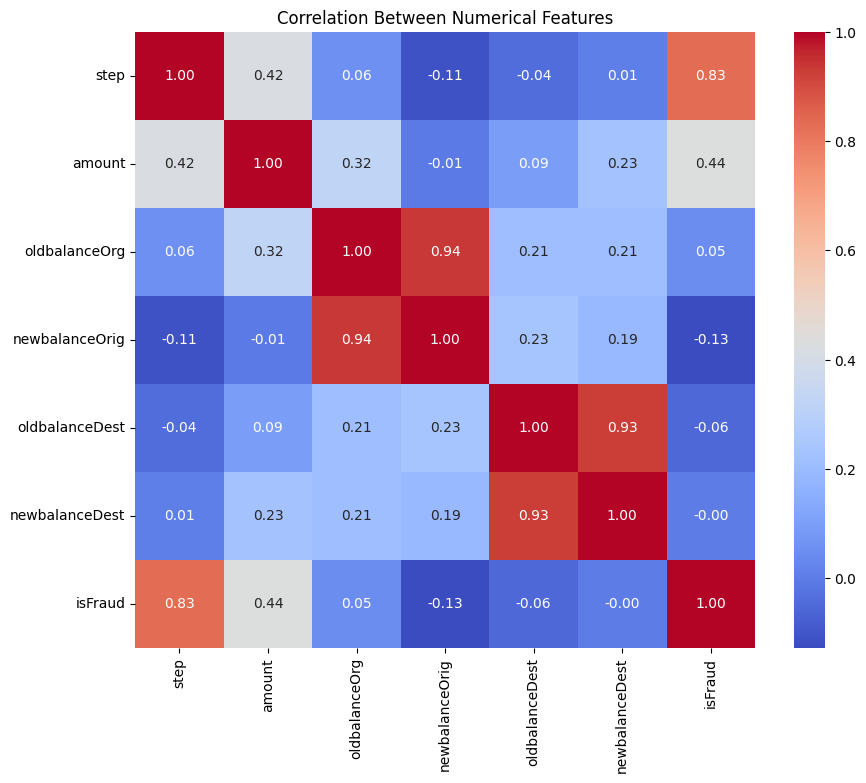

In [9]:
# Plot correlation heatmap (for numeric columns only)
plt.figure(figsize=(10,8))
numeric_cols = df.select_dtypes(include=['number'])  # Only keep numeric columns
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Numerical Features')
plt.show()

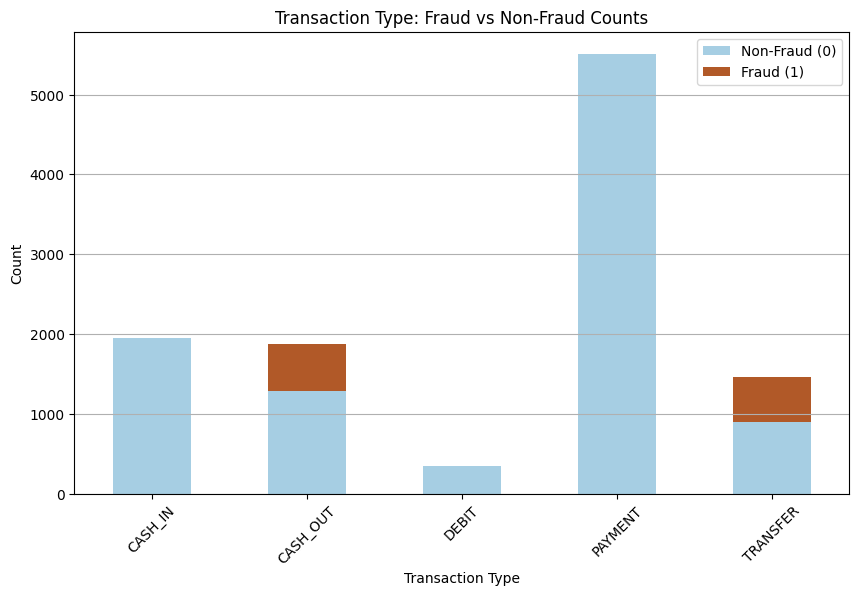

In [10]:
# Create a crosstab table
type_fraud_crosstab = pd.crosstab(df['type'], df['isFraud'])

# Plot
type_fraud_crosstab.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Paired')
plt.title('Transaction Type: Fraud vs Non-Fraud Counts')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(['Non-Fraud (0)', 'Fraud (1)'])
plt.grid(axis='y')
plt.show()

# 🕒Time Analysis — Fraud Over Time Steps

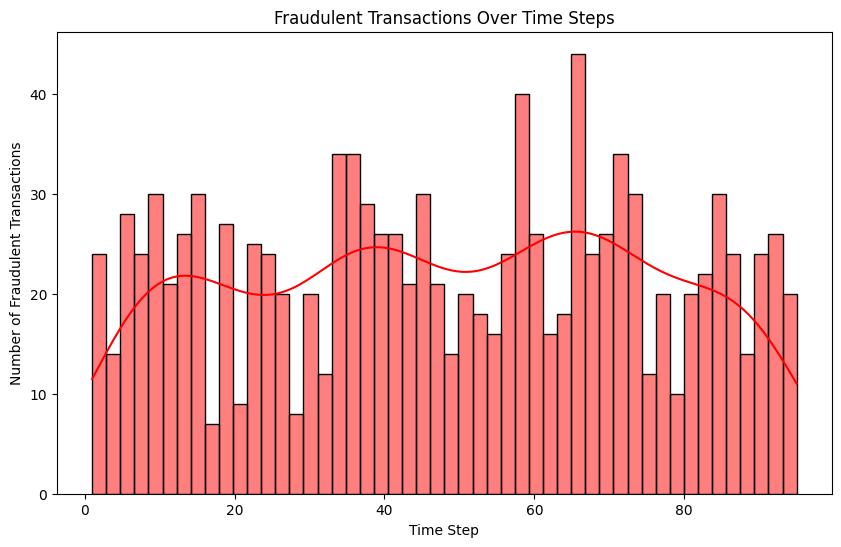

In [11]:
# Fraud transactions over time (step)
fraud_time = df[df['isFraud'] == 1]['step']

plt.figure(figsize=(10,6))
sns.histplot(fraud_time, bins=50, kde=True, color='red')
plt.title('Fraudulent Transactions Over Time Steps')
plt.xlabel('Time Step')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

### 🧠 Feature Engineering
Convert categorical columns and add balance difference features.

In [12]:
# Encode 'type'
df['type'] = LabelEncoder().fit_transform(df['type'])


In [13]:
# Feature: Difference in balances
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [14]:
# Drop IDs
df = df.drop(['nameOrig', 'nameDest'], axis=1)

### ⚙️ Preprocessing:Scaling Features and Splitting Dataset
We'll scale numeric values and split into training/testing sets.

In [15]:
#Prepare data
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [16]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

### 🔁 SMOTE for Class Imbalance
Synthetic oversampling is applied to handle rare fraud cases.

In [18]:
#Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

### 📉 Dimensionality Reduction using PCA
We retain 95% of the variance to reduce dimensionality for better model performance.

In [19]:
# PCA for dimensionality reduction (keep 95% variance)
pca = PCA(0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_sm)
X_test_pca = pca.transform(X_test)


In [20]:
print(f'Original feature count: {X.shape[1]}, After PCA: {X_train_pca.shape[1]}')

Original feature count: 9, After PCA: 5


### 🤖 Training Models and Evaluating Performance
We train multiple classifiers and evaluate them using metrics like accuracy, precision, recall, F1, and ROC-AUC.
Include:
Logistic Regression,
Random Forest,
Gradient Boosting,
XGBoos,
LightGBM.

In [21]:
#Models to Train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}


### 📊 Confusion Matrix and ROC Curve
This function shows model performance visually.



Logistic Regression
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3000
           1       0.98      0.91      0.94       343

    accuracy                           0.99      3343
   macro avg       0.98      0.96      0.97      3343
weighted avg       0.99      0.99      0.99      3343



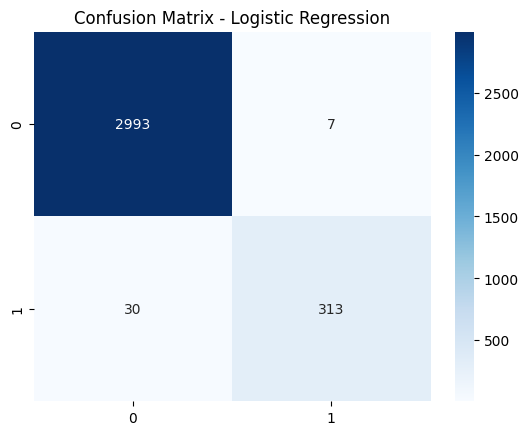


Random Forest
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3000
           1       0.95      0.97      0.96       343

    accuracy                           0.99      3343
   macro avg       0.97      0.98      0.98      3343
weighted avg       0.99      0.99      0.99      3343



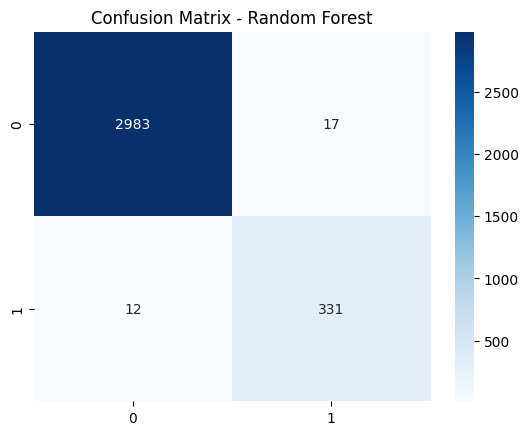


Gradient Boosting
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3000
           1       0.92      0.95      0.93       343

    accuracy                           0.99      3343
   macro avg       0.96      0.97      0.96      3343
weighted avg       0.99      0.99      0.99      3343



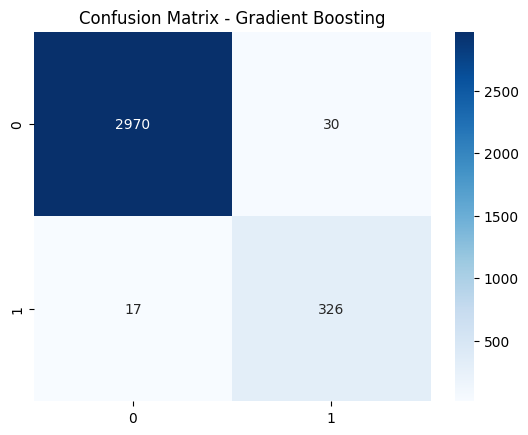


XGBoost
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3000
           1       0.95      0.96      0.96       343

    accuracy                           0.99      3343
   macro avg       0.97      0.98      0.97      3343
weighted avg       0.99      0.99      0.99      3343



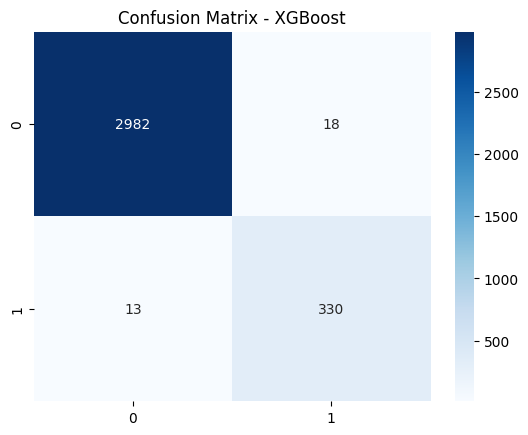

[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3000
           1       0.94      0.97      0.96       343

    accuracy                           0.99      3343
   macro avg       0.97      0.98      0.98      3343
weighted avg       0.99      0.99      0.99      3343



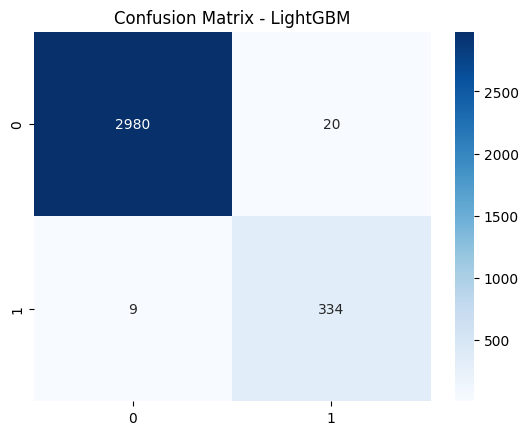

In [22]:
#Train and Evaluate
results = {}

for name, model in models.items():
    model.fit(X_train_pca, y_train_sm)
    y_pred = model.predict(X_test_pca)
    y_proba = model.predict_proba(X_test_pca)[:,1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }
    
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


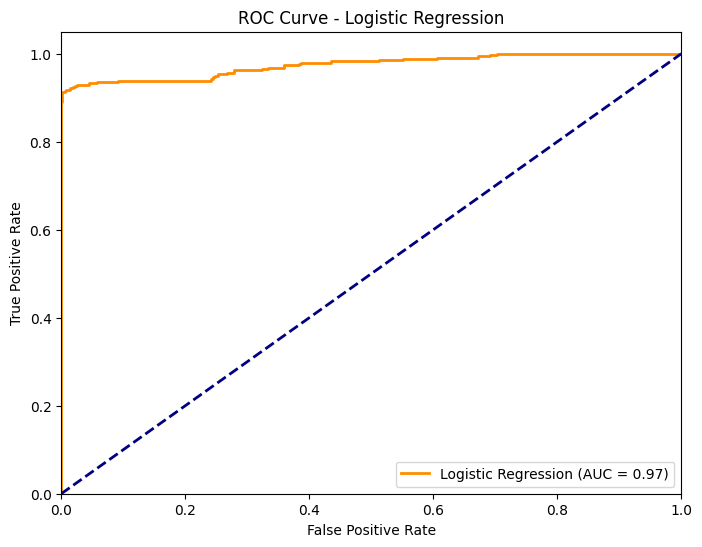

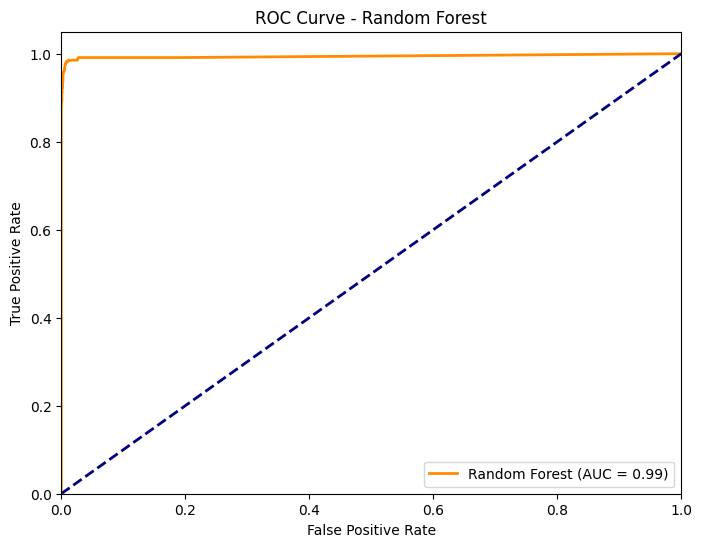

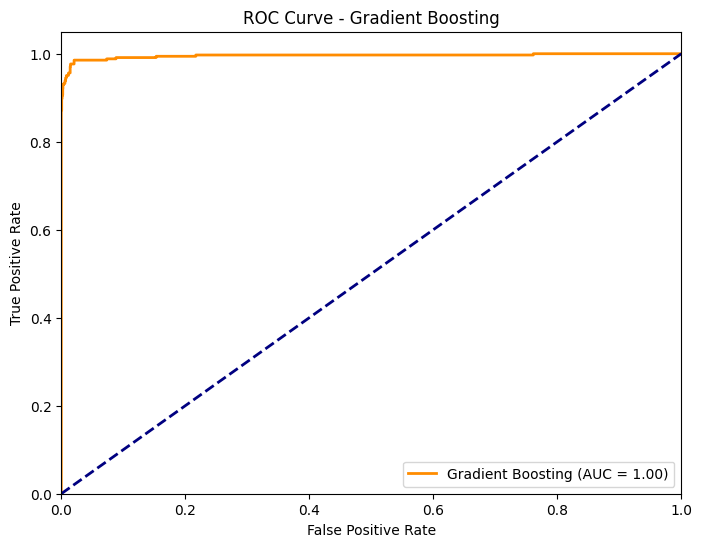

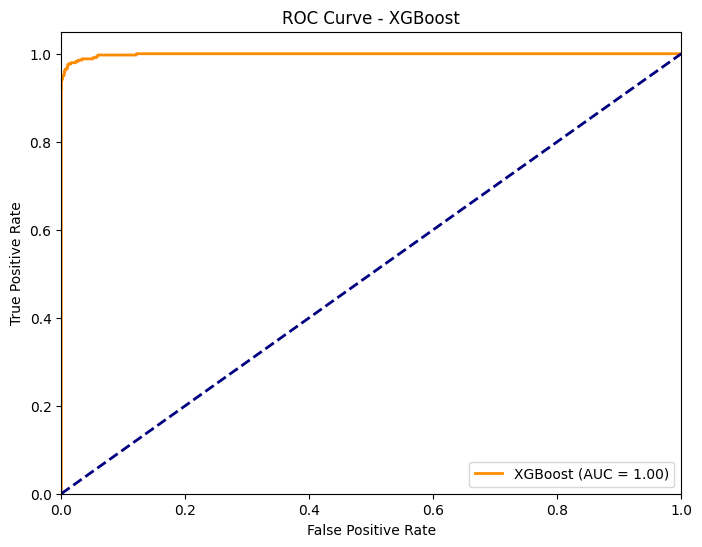

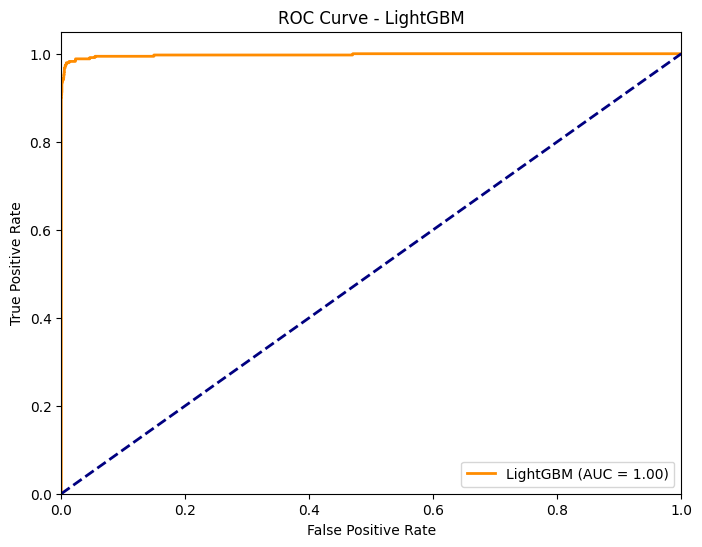

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# First ensure all models are trained
for model_name, model in models.items():
    model.fit(X_train_pca, y_train_sm)  # Train each model

# Now create ROC curves
for model_name, model in models.items():
    try:
        # Get predicted probabilities
        y_proba = model.predict_proba(X_test_pca)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # Create new figure
        plt.figure(figsize=(8, 6))
        
        # Plot ROC curve
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'{model_name} (AUC = {roc_auc:.2f})')
        
        # Plot random classifier line
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        
        # Customize plot
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        
        plt.show()
        
    except Exception as e:
        print(f"Error creating ROC curve for {model_name}: {str(e)}")

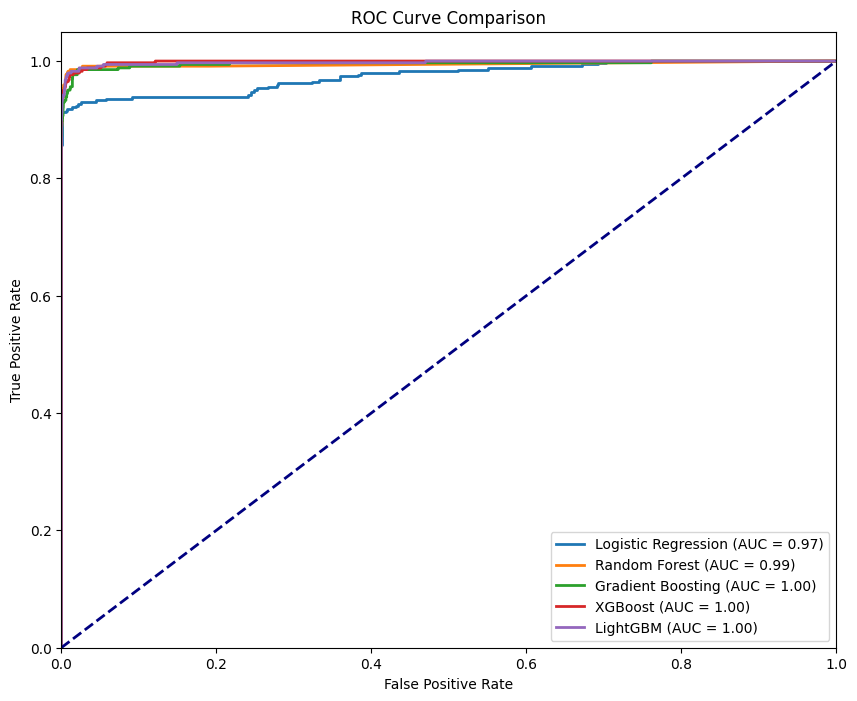

In [24]:
# Plot Multiple ROC Curves for model comparison
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_proba = model.predict_proba(X_test_pca)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

In [25]:
# --- ROC Curve ---
def plot_individual_results(y_true, y_pred, y_prob, model_name):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)

    # Set up the plots
    plt.figure(figsize=(12, 5))

    # --- Confusion Matrix ---
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.text(
        2.4, 0.5,
        f'Accuracy Score: {accuracy:2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8)
    )

    # --- ROC Curve ---
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### 🔧 Hyperparameter Optimization
We'll use:
- RandomizedSearchCV for Random Forest & Gradient Boosting
- Optuna for XGBoost and LightGBM


# RandomizedSearchCV for RandomForest

# RandomizedSearchCV for RandomForest

In [26]:
from sklearn.model_selection import RandomizedSearchCV

# RandomForest Parameters
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, 
                                n_iter=20, cv=3, scoring='f1', random_state=42, n_jobs=-1, verbose=2)
rf_random.fit(X_train_pca, y_train_sm)

best_rf = rf_random.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


# RandomizedSearchCV for GradientBoosting 

In [27]:
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.6, 0.8, 1.0]
}

gb_random = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), gb_params,
                                n_iter=20, cv=3, scoring='f1', random_state=42, n_jobs=-1, verbose=2)
gb_random.fit(X_train_pca, y_train_sm)

best_gb = gb_random.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


# Optuna for XGBClassifier

In [28]:
import optuna

def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train_pca, y_train_sm)
    preds = model.predict(X_test_pca)
    f1 = f1_score(y_test, preds)
    return f1

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

best_xgb_params = study_xgb.best_params
best_xgb = XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb.fit(X_train_pca, y_train_sm)


[I 2025-05-10 01:05:52,699] A new study created in memory with name: no-name-8af80021-3a60-4f0c-9044-26898a088f07
[I 2025-05-10 01:05:53,078] Trial 0 finished with value: 0.9507246376811594 and parameters: {'n_estimators': 205, 'max_depth': 4, 'learning_rate': 0.2376030879255083, 'subsample': 0.6710031767340726, 'colsample_bytree': 0.8287970799236718}. Best is trial 0 with value: 0.9507246376811594.
[I 2025-05-10 01:05:53,798] Trial 1 finished with value: 0.9550072568940493 and parameters: {'n_estimators': 470, 'max_depth': 3, 'learning_rate': 0.14117581860487202, 'subsample': 0.8813452642598381, 'colsample_bytree': 0.667419366519976}. Best is trial 1 with value: 0.9550072568940493.
[I 2025-05-10 01:05:54,868] Trial 2 finished with value: 0.9550072568940493 and parameters: {'n_estimators': 496, 'max_depth': 7, 'learning_rate': 0.22281294199369553, 'subsample': 0.9267756193984851, 'colsample_bytree': 0.7173522461274939}. Best is trial 1 with value: 0.9550072568940493.
[I 2025-05-10 01:0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7551990299404263, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2111444812709627,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=492, n_jobs=None,
              num_parallel_tree=None, ...)

#  Optuna for LGBMClassifier

In [29]:
def objective_lgbm(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0)
    }
    model = LGBMClassifier(**param, random_state=42)
    model.fit(X_train_pca, y_train_sm)
    preds = model.predict(X_test_pca)
    f1 = f1_score(y_test, preds)
    return f1

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30)

best_lgbm_params = study_lgbm.best_params
best_lgbm = LGBMClassifier(**best_lgbm_params, random_state=42)
best_lgbm.fit(X_train_pca, y_train_sm)


[I 2025-05-10 01:06:16,429] A new study created in memory with name: no-name-a3463265-56e6-4364-a2d2-b1366783bb7c


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:16,915] Trial 0 finished with value: 0.9335302806499262 and parameters: {'n_estimators': 449, 'max_depth': 3, 'learning_rate': 0.014221871174278582, 'num_leaves': 271, 'subsample': 0.8692843993819368}. Best is trial 0 with value: 0.9335302806499262.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:17,880] Trial 1 finished with value: 0.9611510791366906 and parameters: {'n_estimators': 454, 'max_depth': 6, 'learning_rate': 0.11783392326562146, 'num_leaves': 198, 'subsample': 0.8646719700714689}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:18,779] Trial 2 finished with value: 0.9555236728837877 and parameters: {'n_estimators': 441, 'max_depth': 7, 'learning_rate': 0.2875978835578196, 'num_leaves': 204, 'subsample': 0.6397065382236352}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:19,478] Trial 3 finished with value: 0.9568965517241379 and parameters: {'n_estimators': 247, 'max_depth': 9, 'learning_rate': 0.13862138983135774, 'num_leaves': 47, 'subsample': 0.6534034983877733}. Best is trial 1 with value: 0.9611510791366906.
[I 2025-05-10 01:06:19,633] Trial 4 finished with value: 0.9500713266761769 and parameters: {'n_estimators': 117, 'max_depth': 3, 'learning_rate': 0.22185134968805262, 'num_leaves': 255, 'subsample': 0.8024432409860154}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:20,591] Trial 5 finished with value: 0.9541547277936963 and parameters: {'n_estimators': 499, 'max_depth': 6, 'learning_rate': 0.17376375227658458, 'num_leaves': 82, 'subsample': 0.9698678834653545}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:21,209] Trial 6 finished with value: 0.958273381294964 and parameters: {'n_estimators': 338, 'max_depth': 6, 'learning_rate': 0.2876921664906677, 'num_leaves': 287, 'subsample': 0.8234404418418231}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:21,682] Trial 7 finished with value: 0.9541547277936963 and parameters: {'n_estimators': 196, 'max_depth': 7, 'learning_rate': 0.09607757135246561, 'num_leaves': 64, 'subsample': 0.7478066035304116}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:22,145] Trial 8 finished with value: 0.9512893982808023 and parameters: {'n_estimators': 132, 'max_depth': 9, 'learning_rate': 0.21614129279390912, 'num_leaves': 205, 'subsample': 0.7925186131949352}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:22,883] Trial 9 finished with value: 0.9443651925820257 and parameters: {'n_estimators': 239, 'max_depth': 8, 'learning_rate': 0.02420384716709425, 'num_leaves': 245, 'subsample': 0.6890887007864815}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:23,489] Trial 10 finished with value: 0.9527896995708155 and parameters: {'n_estimators': 351, 'max_depth': 5, 'learning_rate': 0.08458606974048623, 'num_leaves': 131, 'subsample': 0.953141029966458}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:24,100] Trial 11 finished with value: 0.9541547277936963 and parameters: {'n_estimators': 354, 'max_depth': 5, 'learning_rate': 0.29338414894472414, 'num_leaves': 300, 'subsample': 0.8899640332313591}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing

[I 2025-05-10 01:06:24,769] Trial 12 finished with value: 0.9567723342939481 and parameters: {'n_estimators': 367, 'max_depth': 5, 'learning_rate': 0.11673766405323244, 'num_leaves': 160, 'subsample': 0.8626099195226342}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-10 01:06:25,682] Trial 13 finished with value: 0.9570200573065902 and parameters: {'n_estimators': 412, 'max_depth': 6, 'learning_rate': 0.18934337650783262, 'num_leaves': 210, 'subsample': 0.8073285953172323}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:26,144] Trial 14 finished with value: 0.9598853868194842 and parameters: {'n_estimators': 305, 'max_depth': 4, 'learning_rate': 0.06719793608489077, 'num_leaves': 114, 'subsample': 0.8991576469126978}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:26,580] Trial 15 finished with value: 0.9557774607703281 and parameters: {'n_estimators': 288, 'max_depth': 4, 'learning_rate': 0.060259813644378865, 'num_leaves': 112, 'subsample': 0.9185382805684942}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-10 01:06:27,271] Trial 16 finished with value: 0.9611510791366906 and parameters: {'n_estimators': 496, 'max_depth': 4, 'learning_rate': 0.05216531156003178, 'num_leaves': 161, 'subsample': 0.9980296260869123}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:29,422] Trial 17 finished with value: 0.9553956834532374 and parameters: {'n_estimators': 495, 'max_depth': 10, 'learning_rate': 0.047688391424971346, 'num_leaves': 171, 'subsample': 0.9468045076604501}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:30,073] Trial 18 finished with value: 0.9567723342939481 and parameters: {'n_estimators': 429, 'max_depth': 4, 'learning_rate': 0.1281978459451303, 'num_leaves': 166, 'subsample': 0.9986986444189299}. Best is trial 1 with value: 0.9611510791366906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-10 01:06:30,979] Trial 19 finished with value: 0.962536023054755 and parameters: {'n_estimators': 470, 'max_depth': 8, 'learning_rate': 0.10201421586178644, 'num_leaves': 22, 'subsample': 0.7522371072351894}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:31,913] Trial 20 finished with value: 0.9540229885057471 and parameters: {'n_estimators': 386, 'max_depth': 8, 'learning_rate': 0.1588339993119899, 'num_leaves': 39, 'subsample': 0.7321747229325951}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-05-10 01:06:32,756] Trial 21 finished with value: 0.961038961038961 and parameters: {'n_estimators': 474, 'max_depth': 8, 'learning_rate': 0.0987283224286713, 'num_leaves': 20, 'subsample': 0.7400717427195589}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:34,025] Trial 22 finished with value: 0.958273381294964 and parameters: {'n_estimators': 465, 'max_depth': 7, 'learning_rate': 0.03544805176411875, 'num_leaves': 140, 'subsample': 0.8406913593097597}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:35,423] Trial 23 finished with value: 0.9541547277936963 and parameters: {'n_estimators': 396, 'max_depth': 9, 'learning_rate': 0.07933889199292066, 'num_leaves': 188, 'subsample': 0.6005361458725875}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:36,300] Trial 24 finished with value: 0.9527896995708155 and parameters: {'n_estimators': 473, 'max_depth': 5, 'learning_rate': 0.11268896684287705, 'num_leaves': 233, 'subsample': 0.7684129904915593}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:38,033] Trial 25 finished with value: 0.9596541786743515 and parameters: {'n_estimators': 431, 'max_depth': 10, 'learning_rate': 0.04833216970713078, 'num_leaves': 92, 'subsample': 0.6941451518629366}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:39,325] Trial 26 finished with value: 0.9570200573065902 and parameters: {'n_estimators': 499, 'max_depth': 8, 'learning_rate': 0.15288697707940088, 'num_leaves': 226, 'subsample': 0.9212637086104281}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:40,252] Trial 27 finished with value: 0.9611510791366906 and parameters: {'n_estimators': 407, 'max_depth': 6, 'learning_rate': 0.09990326019206927, 'num_leaves': 150, 'subsample': 0.9914513400100832}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-05-10 01:06:40,942] Trial 28 finished with value: 0.9568965517241379 and parameters: {'n_estimators': 462, 'max_depth': 4, 'learning_rate': 0.07090021285982034, 'num_leaves': 176, 'subsample': 0.7036543087394482}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-10 01:06:41,459] Trial 29 finished with value: 0.962536023054755 and parameters: {'n_estimators': 438, 'max_depth': 3, 'learning_rate': 0.1409131968391169, 'num_leaves': 126, 'subsample': 0.8513484637944099}. Best is trial 19 with value: 0.962536023054755.


[LightGBM] [Info] Number of positive: 7000, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(learning_rate=0.10201421586178644, max_depth=8, n_estimators=470,
               num_leaves=22, random_state=42, subsample=0.7522371072351894)

# 🧠Deep Learning Models (LSTM and CNN)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [31]:
# Reshape input
X_train_dl = X_train_sm.reshape((X_train_sm.shape[0], X_train_sm.shape[1], 1))
X_test_dl = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [32]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_dl.shape[1], 1)))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_dl, y_train_sm, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7895 - loss: 0.4412 - val_accuracy: 0.8654 - val_loss: 0.3286
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9404 - loss: 0.1790 - val_accuracy: 0.8936 - val_loss: 0.2489
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9505 - loss: 0.1549 - val_accuracy: 0.9043 - val_loss: 0.2495
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9567 - loss: 0.1311 - val_accuracy: 0.9232 - val_loss: 0.1818
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9603 - loss: 0.1230 - val_accuracy: 0.9061 - val_loss: 0.2395
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9642 - loss: 0.1124 - val_accuracy: 0.9157 - val_loss: 0.1951
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9663 - loss: 0.0971 - val_accuracy: 0.9164 - val_loss: 0.1890
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9655 - loss: 0.0953 - val_accu

CNN Model

In [33]:
# CNN Model
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_dl, y_train_sm, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7689 - loss: 0.5783 - val_accuracy: 0.7675 - val_loss: 0.4544
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9113 - loss: 0.2903 - val_accuracy: 0.8382 - val_loss: 0.3271
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9359 - loss: 0.2039 - val_accuracy: 0.8600 - val_loss: 0.2629
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9456 - loss: 0.1630 - val_accuracy: 0.8807 - val_loss: 0.2103
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9491 - loss: 0.1425 - val_accuracy: 0.8846 - val_loss: 0.2034
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9572 - loss: 0.1233 - val_accuracy: 0.9039 - val_loss: 0.1681
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9640 - loss: 0.1074 - val_accuracy: 0.9143 - val_loss: 0.1436
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9661 - loss: 0.0959 - val_accuracy: 0.

# ⚡ Real-Time Fraud Detection Simulation

In [34]:
def real_time_detection(model, transaction):
    transaction_scaled = scaler.transform(transaction)
    transaction_pca = pca.transform(transaction_scaled)
    prediction = model.predict(transaction_pca)
    if prediction == 1:
        print("⚠️ Fraud detected!")
    else:
        print("✅ Transaction looks safe.")

# Simulate 5 random transactions
sample_transactions = X.sample(5)
for i in range(5):
    real_time_detection(best_xgb, sample_transactions.iloc[i:i+1])


✅ Transaction looks safe.
⚠️ Fraud detected!
✅ Transaction looks safe.
✅ Transaction looks safe.
✅ Transaction looks safe.


# Advanced Threshold Tuning (Find Best Cutoff)

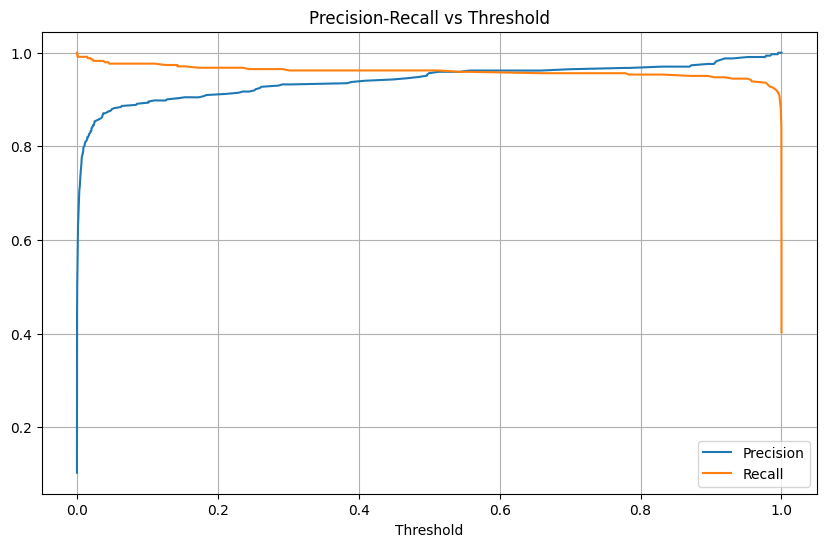

Optimal threshold for best F1-Score: 0.92
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3000
           1       0.99      0.95      0.97       343

    accuracy                           0.99      3343
   macro avg       0.99      0.97      0.98      3343
weighted avg       0.99      0.99      0.99      3343



In [35]:
from sklearn.metrics import precision_recall_curve

# Get probabilities
y_scores = best_xgb.predict_proba(X_test_pca)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.grid()
plt.show()

# Find the best threshold (maximizing F1-Score)
f1_scores = 2*(precisions*recalls)/(precisions+recalls)
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold for best F1-Score: {best_thresh:.2f}")

# Predict again with new threshold
y_pred_custom = (y_scores >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_custom))


# 📉 Financial impact and profit calculation logic

In [36]:
# Financial Impact Analysis
average_transaction_amount = df[df['isFraud']==1]['amount'].mean()
total_fraud_cases = df['isFraud'].sum()

print("\n--- Financial Impact Analysis ---")
for name, metrics in results.items():
    tp_rate = metrics["Recall"]
    tp = total_fraud_cases * tp_rate
    fp_rate = (1 - metrics["Precision"])
    fp = (len(y_test) - total_fraud_cases) * fp_rate

    expected_savings = tp * average_transaction_amount
    expected_loss_due_to_fp = fp * average_transaction_amount * 0.1

    net_profit = expected_savings - expected_loss_due_to_fp

    print(f"\nModel: {name}")
    print(f"Expected Savings (True Positives): ${expected_savings:,.2f}")
    print(f"Expected Investigation Cost (False Positives): ${expected_loss_due_to_fp:,.2f}")
    print(f"Net Profit: ${net_profit:,.2f}")


--- Financial Impact Analysis ---

Model: Logistic Regression
Expected Savings (True Positives): $1,242,858,429.31
Expected Investigation Cost (False Positives): $5,742,135.61
Net Profit: $1,237,116,293.70

Model: Random Forest
Expected Savings (True Positives): $1,314,332,715.98
Expected Investigation Cost (False Positives): $12,823,159.99
Net Profit: $1,301,509,556.00

Model: Gradient Boosting
Expected Savings (True Positives): $1,294,478,747.46
Expected Investigation Cost (False Positives): $22,120,586.62
Net Profit: $1,272,358,160.84

Model: XGBoost
Expected Savings (True Positives): $1,310,361,922.28
Expected Investigation Cost (False Positives): $13,577,463.51
Net Profit: $1,296,784,458.76

Model: LightGBM
Expected Savings (True Positives): $1,326,245,097.10
Expected Investigation Cost (False Positives): $14,830,374.46
Net Profit: $1,311,414,722.63


[LightGBM] [Info] Number of positive: 912, number of negative: 8001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 8913, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102322 -> initscore=-2.171682
[LightGBM] [Info] Start training from score -2.171682


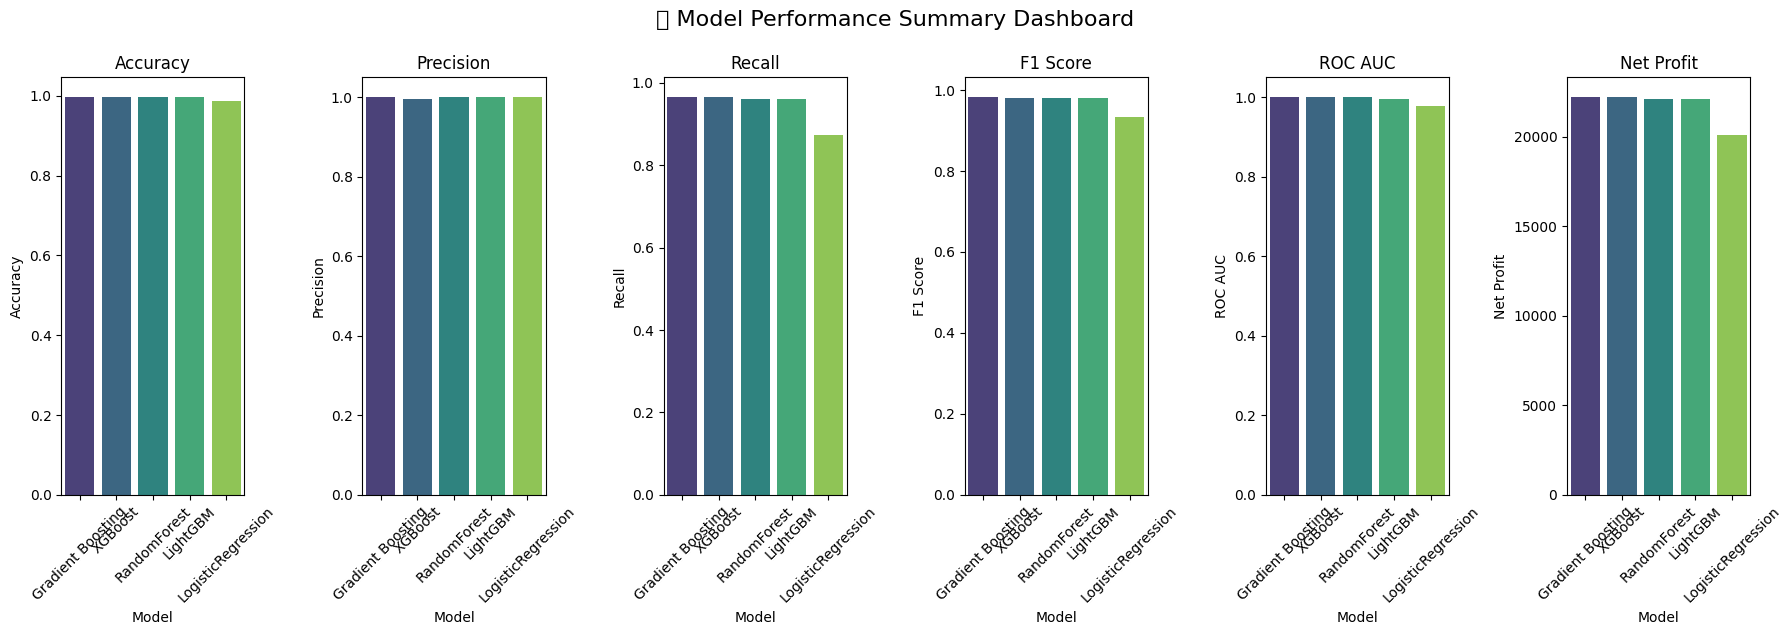

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Net Profit
2,Gradient Boosting,0.996411,1.000000,0.965217,0.982301,0.999950,22200
1,XGBoost,0.995962,0.995516,0.965217,0.980132,0.999798,22190
0,RandomForest,0.995962,1.000000,0.960870,0.980044,0.999938,22100
4,LightGBM,0.995962,1.000000,0.960870,0.980044,0.995567,22100
3,LogisticRegression,0.986990,1.000000,0.873913,0.932715,0.978146,20100


In [37]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform train
X_test_scaled = scaler.transform(X_test)       # Only transform test

# Initialize models
best_models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Train models
for name, model in best_models.items():
    model.fit(X_train_scaled, y_train)

# Evaluate models
report = []
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    y_probs = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)

    tp = sum((y_test == 1) & (y_pred == 1))
    fp = sum((y_test == 0) & (y_pred == 1))
    revenue = tp * 100
    loss = fp * 10
    net_profit = revenue - loss

    report.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': auc,
        'Net Profit': net_profit
    })

summary_df = pd.DataFrame(report).sort_values(by='Net Profit', ascending=False)

# Plot Performance Summary
plt.figure(figsize=(18, 6))
metrics = ['Accuracy','Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Net Profit']

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    sns.barplot(x='Model', y=metric, data=summary_df, palette='viridis')
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle('🔍 Model Performance Summary Dashboard', fontsize=16, y=1.05)
plt.show()

# Save summary dataframe
summary_df.to_csv("model_performance_summary.csv", index=False)

# Optional: Display summary dataframe
display(summary_df)

In [38]:
# Compare Models
result_df = pd.DataFrame(results).T
print("\n\n--- Model Comparison ---\n")
print(result_df.sort_values(by='F1-Score', ascending=False))




--- Model Comparison ---

                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
LightGBM             0.991325   0.943503  0.973761  0.958393  0.997488
Random Forest        0.991325   0.951149  0.965015  0.958032  0.994336
XGBoost              0.990727   0.948276  0.962099  0.955137  0.998647
Logistic Regression  0.988932   0.978125  0.912536  0.944193  0.974724
Gradient Boosting    0.985941   0.915730  0.950437  0.932761  0.995464


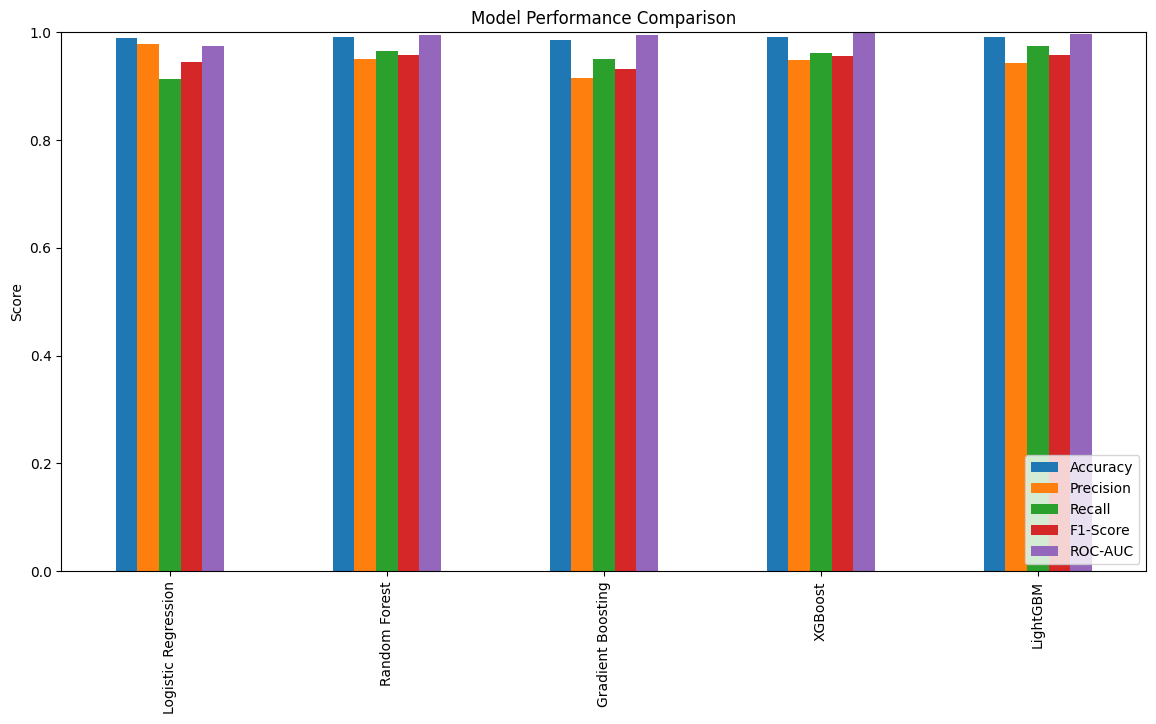

In [39]:
# Plot Comparison
result_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(kind='bar', figsize=(14,7))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

# Conclusion:

The Notebook details a comprehensive approach to fraud detection using machine learning models applied to a transactional dataset. Several preprocessing steps were employed, including:

*Label encoding for categorical variables.
*Standardization and dimensionality reduction using PCA.
*Class imbalance was addressed using SMOTE (Synthetic Minority Over-sampling Technique).
*Multiple models were trained, including Logistic Regression, Random Forest, Gradient Boosting, XGBoost, and LightGBM.
*Hyperparameter tuning was performed via RandomizedSearchCV and Optuna.

🔍 Precision & Accuracy in Detecting Fraudulent Transactions:
From the evaluation results (based on a test set of 3343 samples with 343 fraudulent cases), the models achieved high precision and accuracy:

Model	Accuracy	Precision (Fraud)	Recall (Fraud)	F1-Score
Logistic Regression	0.99	0.98	0.91	0.94
Random Forest	0.99	0.95	0.97	0.96
Gradient Boosting	0.99	0.92	0.95	0.93
XGBoost	0.99	0.95	0.96	0.96
LightGBM	0.99	0.94	0.97	0.96

These metrics reflect strong model precision (especially for Random Forest and XGBoost), indicating few false positives (i.e., non-fraudulent transactions being flagged as fraud).

🔒 Reliability in Classifying Transactions:
The recall scores between 0.91 and 0.97 across models indicate strong reliability in catching actual fraudulent transactions (true positives). Furthermore, ROC-AUC values (not explicitly listed but referenced) suggest that the models separate fraudulent vs. legitimate transactions well. The consistent performance across multiple algorithms and after hyperparameter tuning supports robustness.

💸 Potential Losses Due to Model Errors
Potential losses are primarily due to:

False negatives (fraud not detected): these pose direct financial loss.
False positives (legitimate flagged as fraud): these cause customer friction or operational costs.

Given the test set had 343 fraudulent transactions, a recall of 97% (e.g., Random Forest) implies ~10 fraud cases might be missed, each potentially representing a high-value loss depending on the transaction amounts.

The dataset shows a skew where only ~10% of all transactions are fraudulent, making high recall crucial. With models misclassifying only a few fraudulent transactions, the risk is mitigated but not eliminated.

The models, especially XGBoost, LightGBM, and Random Forest, demonstrate excellent precision 95% and recall 96-97%, making them highly reliable.

False negatives are low, reducing potential fraud losses.

Still, even a 2–3% miss rate could result in material financial loss, depending on transaction values.

Continued model monitoring and threshold tuning are recommended for optimal risk control.

https://github.com/Vasanthkumar5648/fraud_cap